In [1]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import pylab
import numpy as np
import sklearn
from sklearn import linear_model
import sklearn.preprocessing as preprocessing
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from statsmodels.stats import proportion

import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier

import pprint as pp
import calendar

from sklearn.metrics import balanced_accuracy_score, roc_auc_score,accuracy_score

import warnings
warnings.filterwarnings('ignore')

# Data Description From Website

Input variables:
## bank client data:
1 - age (numeric)<br>
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')<br>
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)<br>
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')<br>
5 - default: has credit in default? (categorical: 'no','yes','unknown')<br>
6 - housing: has housing loan? (categorical: 'no','yes','unknown')<br>
7 - loan: has personal loan? (categorical: 'no','yes','unknown')<br>
## related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')<br>
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')<br>
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')<br>
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.<br>
## other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)<br>
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)<br>
14 - previous: number of contacts performed before this campaign and for this client (numeric)<br>
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')<br>
## social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)<br>
17 - cons.price.idx: consumer price index - monthly indicator (numeric)<br>
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)<br>
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)<br>
20 - nr.employed: number of employees - quarterly indicator (numeric)<br>

In [2]:
df = pd.read_csv('bank.csv',sep=';')

In [3]:
df.shape

(4521, 17)

In [4]:
df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [5]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [6]:
print(np.unique(df['y']))
print(np.unique(df['default']))
print(np.unique(df['housing']))
print(np.unique(df['loan']))
print(np.unique(df['pdays']))

['no' 'yes']
['no' 'yes']
['no' 'yes']
['no' 'yes']
[ -1   1   2   3   5   7  28  38  56  57  58  59  60  61  62  63  64  69
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 109
 110 111 112 113 114 115 116 117 118 119 120 122 123 124 126 127 130 131
 133 135 136 137 138 139 140 141 143 144 145 146 147 148 149 150 151 152
 153 154 158 159 160 161 162 164 165 166 167 168 169 170 171 172 173 174
 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192
 193 195 196 197 198 199 201 204 205 206 207 208 209 210 211 212 219 221
 222 223 224 225 227 231 232 234 235 238 239 241 242 244 246 247 248 249
 250 253 254 255 256 258 259 260 261 262 264 265 266 267 268 270 271 272
 273 274 275 278 280 281 282 283 284 286 287 288 291 292 293 294 295 297
 298 299 300 303 305 308 309 311 312 313 315 316 317 319 321 322 323 325
 326 327 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344

In [7]:
months = {'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6, 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec': 12}
df['month'] = df['month'].map(months)

In [8]:
df['default'] = df['default'].apply(lambda row: 1 if row == 'yes' else 0)
df['housing'] = df['housing'].apply(lambda row: 1 if row == 'yes' else 0)
df['loan'] = df['loan'].apply(lambda row: 1 if row == 'yes' else 0)
df['y'] = df['y'].apply(lambda row: 1 if row == 'yes' else 0)

‘pdays’ column indicates the number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted). If the value of ‘pdays’ is ‘-1’, will associate that with a value of 0,

In [9]:
df['pdays'] = df['pdays'].apply(lambda row: 0 if row == -1 else 1)

In [10]:
# df[['default','is_default']].tail(10)

In [11]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,0,1787,0,0,cellular,19,10,79,1,0,0,unknown,0
1,33,services,married,secondary,0,4789,1,1,cellular,11,5,220,1,1,4,failure,0
2,35,management,single,tertiary,0,1350,1,0,cellular,16,4,185,1,1,1,failure,0
3,30,management,married,tertiary,0,1476,1,1,unknown,3,6,199,4,0,0,unknown,0
4,59,blue-collar,married,secondary,0,0,1,0,unknown,5,5,226,1,0,0,unknown,0


In [12]:

df = pd.get_dummies(df)

In [13]:

# df.drop('marital_divorced', axis=1, inplace=True)
# df.drop('job_unknown', axis=1, inplace=True)
# df.drop('education_unknown', axis=1, inplace=True)
# df.drop('contact_unknown', axis=1, inplace=True)
# df.drop('poutcome_unknown', axis=1, inplace=True)

In [14]:
df.dtypes

age                    int64
default                int64
balance                int64
housing                int64
loan                   int64
day                    int64
month                  int64
duration               int64
campaign               int64
pdays                  int64
previous               int64
y                      int64
job_admin.             uint8
job_blue-collar        uint8
job_entrepreneur       uint8
job_housemaid          uint8
job_management         uint8
job_retired            uint8
job_self-employed      uint8
job_services           uint8
job_student            uint8
job_technician         uint8
job_unemployed         uint8
job_unknown            uint8
marital_divorced       uint8
marital_married        uint8
marital_single         uint8
education_primary      uint8
education_secondary    uint8
education_tertiary     uint8
education_unknown      uint8
contact_cellular       uint8
contact_telephone      uint8
contact_unknown        uint8
poutcome_failu

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
x, y = df.drop('y', axis=1), df['y']
x.shape, y.shape

((4521, 37), (4521,))

In [17]:
X_train, X_test, y_train, y_test= train_test_split(x,y, test_size=.2, random_state=42)

In [18]:
## extract sensitive features
# A = X_test["default"].map({1:"yes",0:"no"})
# A_str_test = X_test["default"]
# A_ = X_train["default"].map({1:"yes",0:"no"})
# A_str_train = X_train["default"]

A = X_test["age"].apply(lambda row: 1 if row <=30 else 0)
A_str_test = X_test["age"]
A_ = X_train["age"].apply(lambda row: 1 if row <=30 else 0)
A_str_train = X_train["age"]

In [19]:
# binarize age for test and train
X_train["age"] = X_train["age"].apply(lambda row: 1 if row <=30 else 0)
X_test["age"]= X_test["age"].apply(lambda row: 1 if row <=30 else 0)

In [20]:
X_train

,age,default,balance,housing,loan,day,month,duration,campaign,pdays,...,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
978,0,0,262,0,0,20,11,371,1,0,...,0,1,0,1,0,0,0,0,0,1
251,0,0,2349,0,0,14,8,134,5,0,...,0,1,0,1,0,0,0,0,0,1
3139,0,0,1076,0,0,8,8,70,2,0,...,1,0,0,1,0,0,0,0,0,1
1822,0,0,156,0,0,13,8,657,7,0,...,0,1,0,1,0,0,0,0,0,1
4445,0,0,258,1,0,27,5,217,1,0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4426,0,0,1536,0,0,4,5,54,2,0,...,0,1,0,1,0,0,0,0,0,1
466,0,0,-370,1,0,21,5,748,1,0,...,1,0,0,0,0,1,0,0,0,1
3092,0,0,523,1,0,6,5,105,4,1,...,0,1,0,1,0,0,1,0,0,0
3772,0,0,440,0,0,21,8,71,4,0,...,0,1,0,1,0,0,0,0,0,1


In [21]:
import scipy.stats as ss

In [22]:
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier

# Data processing
from sklearn.model_selection import train_test_split

# Fairlearn algorithms and utils
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import GridSearch, EqualizedOdds

# Metrics
from fairlearn.metrics import (
    MetricFrame,
    selection_rate, demographic_parity_difference, demographic_parity_ratio,
    false_positive_rate, false_negative_rate,
    false_positive_rate_difference, false_negative_rate_difference,
    equalized_odds_difference, count)

from sklearn.metrics import balanced_accuracy_score, roc_auc_score,accuracy_score

In [23]:
# Models
import lightgbm as lgb
from sklearn.calibration import CalibratedClassifierCV

lgb_params = {
    'objective' : 'binary',
    'metric' : 'auc', 
    'learning_rate': 0.1,
    'num_leaves' : 10,
    'max_depth' : 3
}

model = lgb.LGBMClassifier(**lgb_params)

In [24]:
train_data = X_train
train_labels = y_train
test_data = X_test
test_labels = y_test
model.fit(train_data, train_labels)

LGBMClassifier(max_depth=3, metric='auc', num_leaves=10, objective='binary')

In [25]:
# Scores on test set
test_scores = model.predict_proba(test_data)[:, 1]
test_pred = model.predict(test_data)

In [26]:
# Train AUC
roc_auc_score(train_labels, model.predict_proba(train_data)[:, 1])

0.9460921830333642

In [27]:
# ACCURACY
accuracy_score(test_labels, test_pred)

0.8994475138121547

In [28]:
# Predictions (0 or 1) on test set
test_preds = (test_scores >= np.mean(train_labels)) * 1

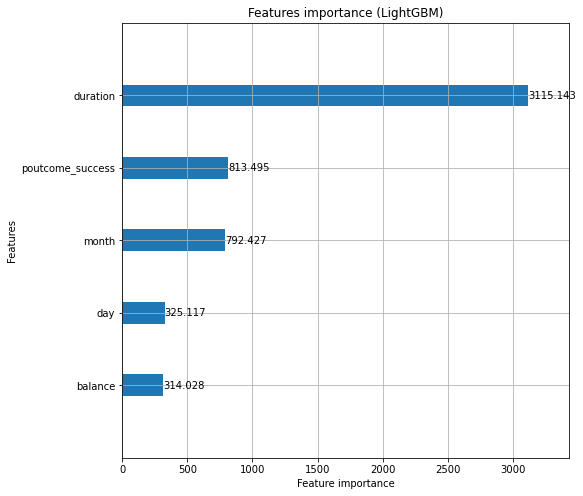

In [29]:
# LightGBM feature importance 
lgb.plot_importance(model, figsize = (8,8), height=0.3, title="Features importance (LightGBM)", importance_type="gain", max_num_features=5) 
plt.show()

In [30]:
# USE FAIRLEARN now
# use MetricFrame for analysis 
##     selection_rate, demographic_parity_difference, demographic_parity_ratio,
##    false_positive_rate, false_negative_rate,
##    false_positive_rate_difference, false_negative_rate_difference,
##    equalized_odds_difference, count



mf = MetricFrame({
    'FPR': false_positive_rate,
    'FNR': false_negative_rate},
    test_labels, test_preds, sensitive_features=A_str_test)

mf.by_group

,FPR,FNR
age,,
0,0.195467,0.125
1,0.247525,0.166667


In [31]:
# Helper functions
def get_metrics_df(models_dict, y_true, group):
    metrics_dict = {
#         "Overall selection rate": (
#             lambda x: selection_rate(y_true, x), True),
        "Demographic parity difference": (
            lambda x: demographic_parity_difference(y_true, x, sensitive_features=group), True),
#         "Demographic parity ratio": (
#             lambda x: demographic_parity_ratio(y_true, x, sensitive_features=group), True),
#         "------": (lambda x: "", True),
#         "Overall balanced error rate": (
#             lambda x: 1-balanced_accuracy_score(y_true, x), True),
#         "Balanced error rate difference": (
#             lambda x: MetricFrame(metrics=balanced_accuracy_score, y_true=y_true, y_pred=x, sensitive_features=group).difference(method='between_groups'), True),
#         " ------": (lambda x: "", True),
#         "False positive rate difference": (
#             lambda x: false_positive_rate_difference(y_true, x, sensitive_features=group), True),
#         "False negative rate difference": (
#             lambda x: false_negative_rate_difference(y_true, x, sensitive_features=group), True),
        "Equalized odds difference": (
            lambda x: equalized_odds_difference(y_true, x, sensitive_features=group), True),
        "  ------": (lambda x: "", True),
        "Accuracy": (
             lambda x: accuracy_score(y_true, x), True)
#         "Overall AUC": (
#             lambda x: roc_auc_score(y_true, x), False),
#         "AUC difference": (
#             lambda x: MetricFrame(metrics=roc_auc_score, y_true=y_true, y_pred=x, sensitive_features=group).difference(method='between_groups'), False),
    }
    df_dict = {}
    for metric_name, (metric_func, use_preds) in metrics_dict.items():
        df_dict[metric_name] = [metric_func(preds) if use_preds else metric_func(scores) 
                                for model_name, (preds, scores) in models_dict.items()]
    return pd.DataFrame.from_dict(df_dict, orient="index", columns=models_dict.keys())

In [32]:
models_dict = {"Unmitigated": (test_preds, test_scores)}
get_metrics_df(models_dict, test_labels, A_str_test)

,Unmitigated
Demographic parity difference,0.0715034
Equalized odds difference,0.0520573
------,
Accuracy,0.805525


## Threshold Optimizer w Demographic Parity 

In [33]:
import pprint

postprocess_est = ThresholdOptimizer(
    estimator = model,
    constraints="demographic_parity",
    prefit=True)

balanced_idx1 = train_data[train_labels==1].index
pp_train_idx = balanced_idx1.union(train_labels[train_labels==0].sample(n=balanced_idx1.size, random_state=1234).index)
df_train_balanced = train_data.loc[pp_train_idx, :]
Y_train_balanced = train_labels.loc[pp_train_idx]
A_train_balanced = A_.loc[pp_train_idx]


postprocess_est.fit(df_train_balanced, Y_train_balanced, sensitive_features=A_train_balanced)

postprocess_preds = postprocess_est.predict(test_data, sensitive_features= A)


models_dict = {"Unmitigated": (test_preds, test_scores),
              "ThresholdOptimizer": (postprocess_preds, postprocess_preds)}
(get_metrics_df(models_dict, test_labels, A_str_test))

,Unmitigated,ThresholdOptimizer
Demographic parity difference,0.0715034,0.000801847
Equalized odds difference,0.0520573,0.0155948
------,,
Accuracy,0.805525,0.899448


## Threshold Optimizer w Equalized Odds

In [34]:
import pprint

postprocess_est = ThresholdOptimizer(
    estimator = model,
    constraints="equalized_odds",
    prefit=True)

balanced_idx1 = train_data[train_labels==1].index
pp_train_idx = balanced_idx1.union(train_labels[train_labels==0].sample(n=balanced_idx1.size, random_state=1234).index)
df_train_balanced = train_data.loc[pp_train_idx, :]
Y_train_balanced = train_labels.loc[pp_train_idx]
A_train_balanced = A_.loc[pp_train_idx]


postprocess_est.fit(df_train_balanced, Y_train_balanced, sensitive_features=A_train_balanced)

postprocess_preds = postprocess_est.predict(test_data, sensitive_features= A)


models_dict = {"Unmitigated": (test_preds, test_scores),
              "ThresholdOptimizer": (postprocess_preds, postprocess_preds)}
(get_metrics_df(models_dict, test_labels, A_str_test))

,Unmitigated,ThresholdOptimizer
Demographic parity difference,0.0715034,0.00793294
Equalized odds difference,0.0520573,0.0152778
------,,
Accuracy,0.805525,0.897238


## Exponentiated Gradient w Demographic Parity

In [35]:
from fairlearn.reductions import ExponentiatedGradient,EqualizedOdds,DemographicParity
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10)
xgc = XGBClassifier(verbosity=0)

eg = ExponentiatedGradient(estimator= model, constraints= DemographicParity())
eg.fit(train_data,train_labels, sensitive_features=A_)
eg_test_preds = eg.predict(test_data)

models_dict = {"Unmitigated": (test_preds, test_scores),
              "ExponentiatedGrad": (eg_test_preds,eg_test_preds)}
(get_metrics_df(models_dict, test_labels, A_str_test))

,Unmitigated,ExponentiatedGrad
Demographic parity difference,0.0715034,0.00174268
Equalized odds difference,0.0520573,0.0155948
------,,
Accuracy,0.805525,0.901657


## Exponentiated Gradient w equalized odds

In [36]:
from fairlearn.reductions import ExponentiatedGradient,EqualizedOdds,DemographicParity
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10)
xgc = XGBClassifier(verbosity=0)

eg = ExponentiatedGradient(estimator= model, constraints= EqualizedOdds())
eg.fit(train_data,train_labels, sensitive_features=A_)
eg_test_preds = eg.predict(test_data)

models_dict = {"Unmitigated": (test_preds, test_scores),
              "ExponentiatedGrad": (eg_test_preds,eg_test_preds)}
(get_metrics_df(models_dict, test_labels, A_str_test))

,Unmitigated,ExponentiatedGrad
Demographic parity difference,0.0715034,0.0160049
Equalized odds difference,0.0520573,0.120833
------,,
Accuracy,0.805525,0.901657
